**Machine Learning for Time Series (Master MVA)**

- [Link to the class material.](http://www.laurentoudre.fr/ast.html)

# Introduction

In this tutorial, we illustrate the following concepts:

- signal prediction,
- model a signal in trend, seasonality and stationary process,
- the AR and MA processes,
- the singular spectrum analysis (SSA).

## Setup

**Imports**

In [1]:
import datetime as dt

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from loadmydata.load_nyc_taxi import load_nyc_taxi_dataset
from numpy.fft import rfft, rfftfreq
from numpy.polynomial.polynomial import Polynomial
from scipy.cluster import hierarchy
from scipy.signal import argrelmax, periodogram
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.stattools import acf, adfuller, kpss, pacf

**Utility functions**

In [2]:
try:
    from numpy.lib.stride_tricks import sliding_window_view  # New in version 1.20.0

    def get_trajectory_matrix(arr, window_shape, jump=1):
        return sliding_window_view(x=arr, window_shape=window_shape)[::jump]

except ImportError:

    def get_trajectory_matrix(arr, window_shape, jump=1):
        n_rows = ((arr.size - window_shape) // jump) + 1
        n = arr.strides[0]
        return np.lib.stride_tricks.as_strided(
            arr, shape=(n_rows, window_shape), strides=(jump * n, n)
        )

In [3]:
def fig_ax(figsize=(15, 4)):
    return plt.subplots(figsize=figsize)

In [4]:
def get_largest_local_max(
    signal1D: np.ndarray, n_largest: int = 3, order: int = 1
) -> [np.ndarray, np.ndarray]:
    """Return the largest local max and the associated index in a tuple.

    This function uses `order` points on each side to use for the comparison.
    """
    all_local_max_indexes = argrelmax(signal1D, order=order)[0]
    all_local_max = np.take(signal1D, all_local_max_indexes)
    largest_local_max_indexes = all_local_max_indexes[all_local_max.argsort()[::-1]][
        :n_largest
    ]

    return (
        np.take(signal1D, largest_local_max_indexes),
        largest_local_max_indexes,
    )

In [5]:
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

In [6]:
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)

In [7]:
def average_anti_diag(traj_matrix: np.ndarray) -> np.ndarray:
    """Average anti diagonal elements of a 2d array"""
    x1d = [
        np.mean(traj_matrix[::-1, :].diagonal(i))
        for i in range(-traj_matrix.shape[0] + 1, traj_matrix.shape[1])
    ]
    return np.array(x1d)

## Fourier analysis

### Aliasing

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Generate four pure sine waves with the following frequencies: 261.63 Hz, 43838.37 Hz, 196 Hz, 43904 Hz. Set the duration to 3 seconds and the sampling frequency to 44.1 kHz.</p>
    <p>Listen to the signal. What do you observe? Explain.</p>
</div>

In [8]:
from IPython.display import Audio

# set the sampling frequency
fs = 44100

# set the duration
duration = 3

# set the frequencies
frequencies = [261.63, 43838.37, 196, 43904]

# generate the sine waves
sine_waves = [np.sin(2*np.pi*np.arange(fs*duration)*f/fs) for f in frequencies]

# concatenate the sine waves
signal = np.concatenate(sine_waves)

# listen to the signal
Audio(signal, rate=fs)

aliasing (repliement de spectre), on ne peut pas faire la différence entre $f$ et $fs - f$, il faudrait que la fréquence soit inférieure à la fréquence de Nyquist.

In [9]:
fs - 261.63

43838.37

### Spectral leakage

Compute and display the DFT of a pure sine wave of frequency $f=1.5$ Hz.
Set the duration to 3 seconds and the sampling frequency to 5 Hz.

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What is the expected DFT shape? What do you observe?</p>
    <p>How to cope with this phenomenon.</p>
</div>

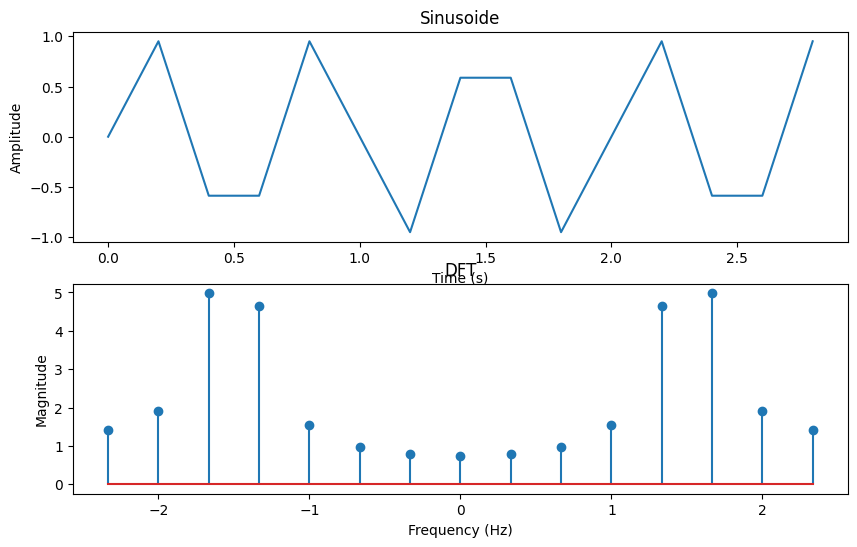

In [11]:
duration = 3 
sampling_freq = 5 
frequency = 1.5
num_samples = duration*sampling_freq
time = np.arange(0, duration, 1/sampling_freq)
signal = np.sin(2*np.pi*frequency*time)
# Compute the DFT
dft = np.fft.fft(signal)
freqs = np.fft.fftfreq(len(dft)) * sampling_freq
# Visualize
plt.figure(figsize=(10, 6))
plt.subplot(2, 1, 1)
plt.plot(time, signal)
plt.title("Sinusoide")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.subplot(2, 1, 2)
plt.stem(freqs, np.abs(dft))
plt.title("DFT")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.show()

Un pic aurait dû être observé à 1.5 Hz; distribution de l'énergie de la fréquence distribuée sur les fréquences voisines.
Comment approcher mieux le spectre et éviter ainsi le spectral leakage ? Augmenter fs ou grille qui tombe directement sur 1.5 Hz.

## Data

In [13]:
X, _, description = load_nyc_taxi_dataset()
print(description)

This data set contains the number of New York taxi passengers aggregated in 30 minutes buckets for the period between July 2014 and January 2015. There are five anomalies occur during the NYC marathon, Thanksgiving, Christmas, New Years day, and a snow storm.

The raw data is from the NYC Taxi and Limousine Commission [1] and has been curated by [2].

[1]: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page 
[2]: Ahmad, S., Lavin, A., Purdy, S., & Agha, Z. (2017). Unsupervised real-time anomaly detection for streaming data. Neurocomputing.


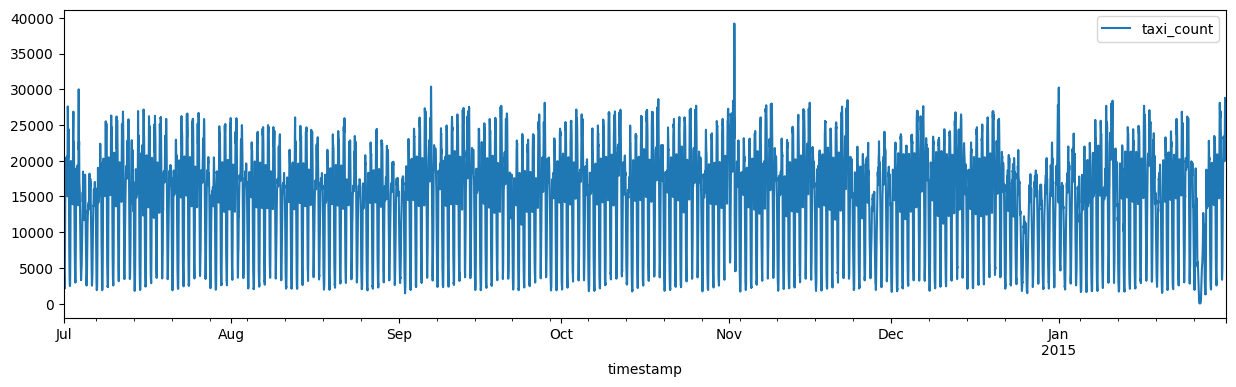

In [14]:
fig, ax = fig_ax()
_ = X.plot(x="timestamp", y="taxi_count", ax=ax)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Plot the taxi count for October and 2014-10-12.</p>
</div>

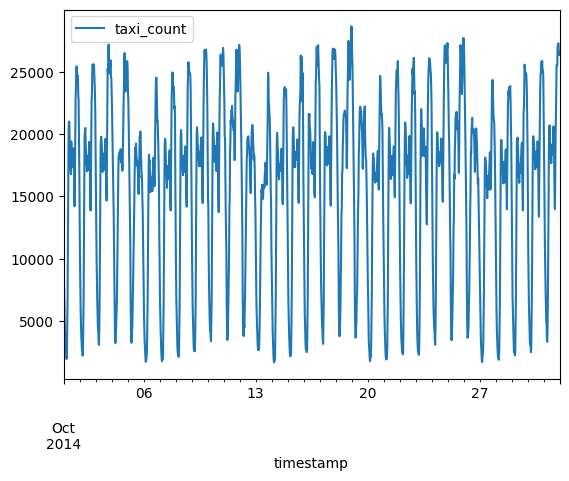

In [33]:
X[X['timestamp'].dt.month==10].plot(y="taxi_count", x="timestamp");

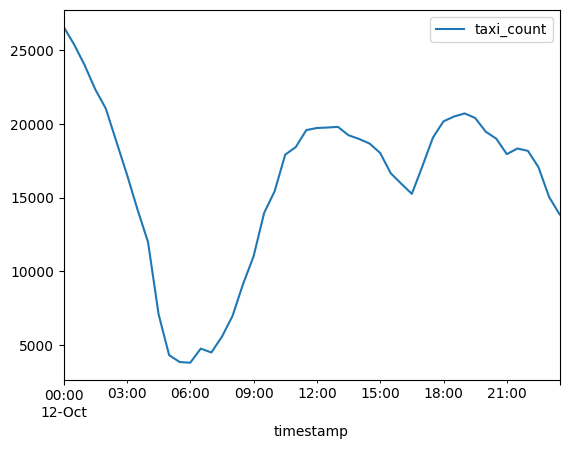

In [32]:
X.set_index("timestamp").loc["2014-10-12"].plot();

## Daily count

In this tutorial, we are interested in the evolution in the **daily** count.
To that end, we resample the original signal.

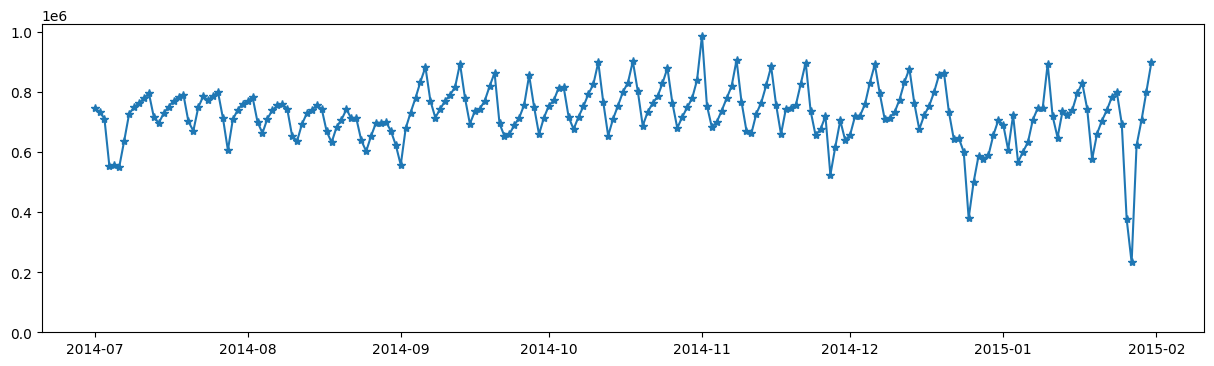

In [44]:
daily_taxi_count = X.resample("1D", on="timestamp").sum()
daily_taxi_count_np = daily_taxi_count.to_numpy().squeeze()
fig, ax = fig_ax()
ax.plot(daily_taxi_count, "*-")
_ = ax.set_ylim(0)

In [37]:
daily_taxi_count

,taxi_count
timestamp,
2014-07-01,745967
2014-07-02,733640
2014-07-03,710142
2014-07-04,552565
2014-07-05,555470
...,...
2015-01-27,232058
2015-01-28,621483
2015-01-29,704935


<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Plot the daily count in October 2014. What can you observe?</p>
</div>

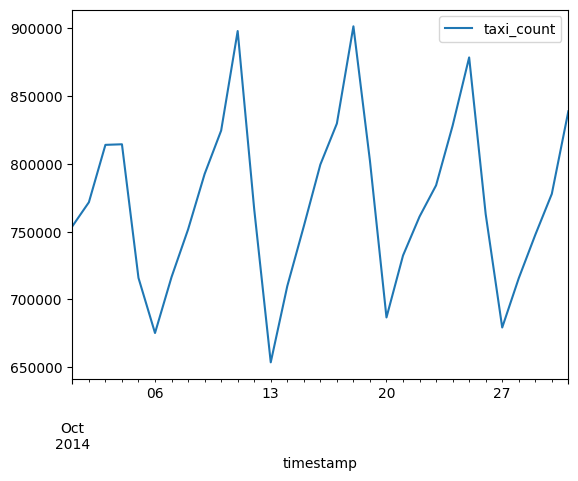

In [38]:
daily_taxi_count.loc["2014-10"].plot();

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What are the important periodicities in the original signal?</p>
</div>

Périodique hebdomadaire.

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Plot or print the average count per hour of the day. Which time is the busiest?</p>
</div>

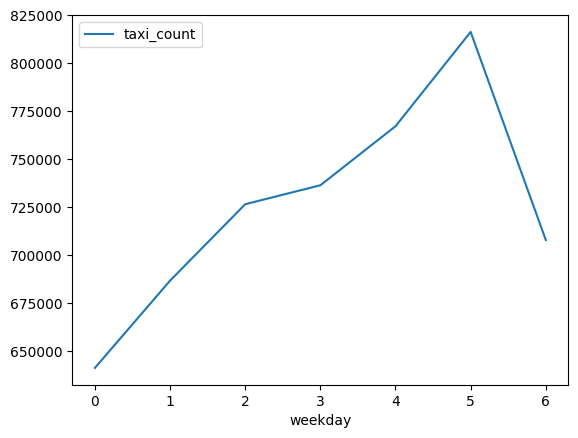

In [47]:
data_ = daily_taxi_count.copy()
data_['weekday']=daily_taxi_count.reset_index().timestamp.dt.weekday.values
data_.groupby('weekday').mean().plot();

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Plot or print the average count per day of the week. Which day is the busiest?</p>
</div>

# Signal Prediction

The objective is to predict the daily taxi for the next two weeks (14 days).
First, we prepare the training and testing data.

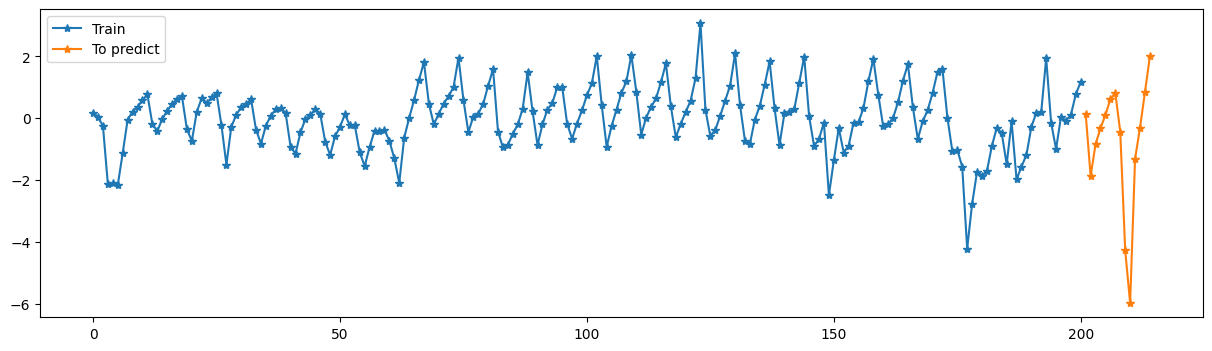

In [48]:
n_samples_pred = 14  # predict the next 14 samples

# train/test split
signal_train, signal_pred = np.split(
    daily_taxi_count_np.astype(float), [-n_samples_pred]
)
n_samples = n_samples_train = signal_train.size

# scaling
scaler = StandardScaler().fit(signal_train.reshape(-1, 1))
signal_train = scaler.transform(signal_train.reshape(-1, 1)).flatten()
signal_pred = scaler.transform(signal_pred.reshape(-1, 1)).flatten()

# keep the indexes of train and test (for plotting mostly)
time_array_train, time_array_pred = np.split(
    np.arange(daily_taxi_count_np.size), [-n_samples_pred]
)
time_array = time_array_train
calendar_time_array = daily_taxi_count.iloc[time_array].index.to_numpy()

# plot
fig, ax = fig_ax()
ax.plot(time_array_train, signal_train, "-*", label="Train")
ax.plot(time_array_pred, signal_pred, "-*", label="To predict")
_ = plt.legend()

## Trend

Three trend estimation methods are tested:

- constant trend,
- linear trend,
- polynomial trend.

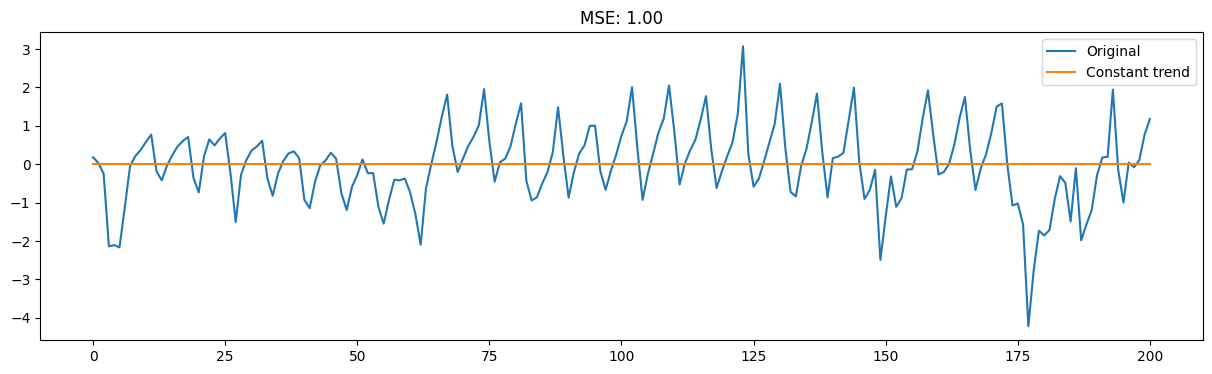

In [49]:
fig, ax = fig_ax()
ax.plot(signal_train, label="Original")

level = signal_train.mean()  # should be zero
approx_trend = level * np.ones(signal_train.size)
ax.plot(approx_trend, label="Constant trend")
ax.set_title(f"MSE: {(signal_train-approx_trend).var():.2f}")
_ = plt.legend()

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Plot the best linear approximation and polynomial approximation (deg=13) of the signal. What are the associated MSE?</p>
</div>

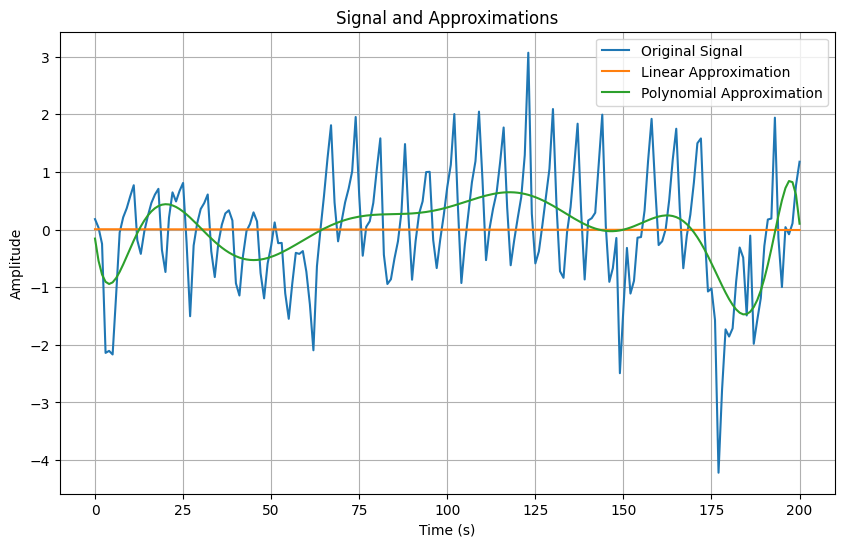

In [51]:
deg = 1 # degree of the polynomial for linear approximation
coeffs = np.polyfit(time_array_train, signal_train, deg)
linear_approx = np.polyval(coeffs, time_array_train)

deg = 13 # degree of the polynomial for polynomial approximation
coeffs = np.polyfit(time_array_train, signal_train, deg)
polynomial_approx = np.polyval(coeffs, time_array_train)

plt.figure(figsize=(10, 6))
plt.plot(time_array_train, signal_train, label='Original Signal')
plt.plot(time_array_train, linear_approx, label='Linear Approximation')
plt.plot(time_array_train, polynomial_approx, label='Polynomial Approximation')
plt.title('Signal and Approximations')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>In the previous cell, show the trend predicted by the polynomial fit in the next 14 samples. What do you conclude?</p>
</div>

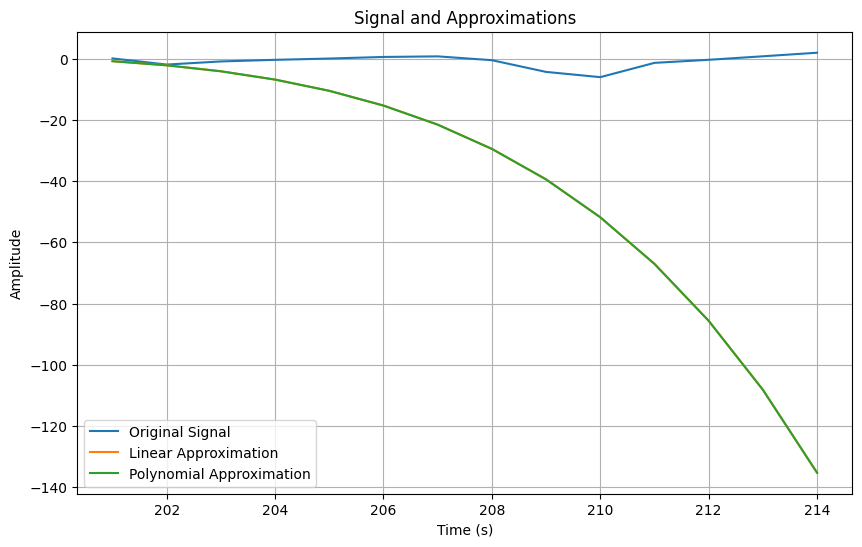

In [56]:
polynomial_approx_pred = np.polyval(coeffs, time_array_pred)

plt.figure(figsize=(10, 6))
plt.plot(time_array_pred, signal_pred, label='Original Signal')
plt.plot(time_array_pred, polynomial_approx_pred, label='Linear Approximation')
plt.plot(time_array_pred, polynomial_approx_pred, label='Polynomial Approximation')
plt.title('Signal and Approximations')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

Comportement asymptotique avec explosion à l'infini quand on sort de l'intervalle (e.g. pour la prédiction) car tous les degrés sont utilisés pour fitter au signal d'entrainement. Et aussi penser au phénomène de Runge.

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>To conclude, which trend do you choose?</p>
</div>

Tendance constante (= 0).

## Seasonality

The seasonality is the periodical component in the signal at hand.

**Finding the harmonic frequencies.**

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Give two ways to estimate the presence of seasonalities.</p>
</div>


autocorrelation et (DFT) PSD

The DFT is not a consistent estimator of the power spectral density.
In practice, the periodogram (or any other variations) is prefered: the DTF is computed over several (possibly overlapping) windows and averaged.

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Modify the code above to estimate the main seasonality from the <b>original</b> signal. What do you conclude?</p>
</div>


Main seasonalities: [24. 12.]


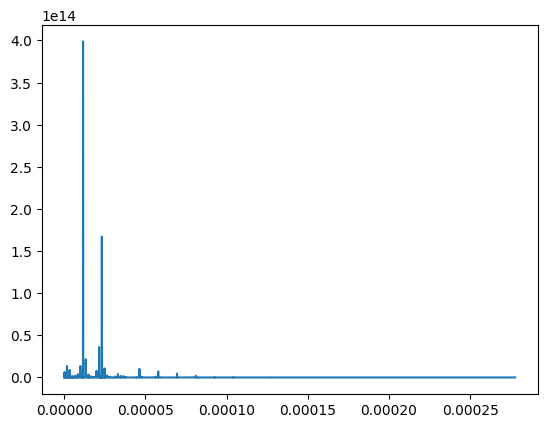

In [58]:
from scipy.signal import periodogram

frequencies, psd = periodogram(X.taxi_count.to_numpy(), fs=1/(30*60))
plt.plot(frequencies, psd)
max_psd, max_psd_idx = get_largest_local_max(psd, n_largest=2, order=1)
print(f"Main seasonalities: {1/(3600*frequencies[max_psd_idx])}")

La périodicité de 12h est un artefact au vu des données que l'on observe.

Main seasonalities: [ 6.93548387 30.71428571]


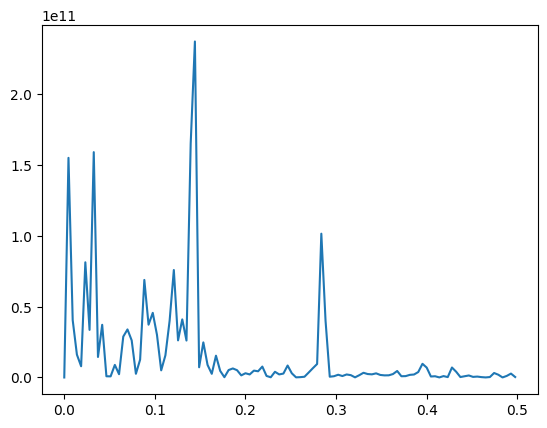

In [61]:
from scipy.signal import periodogram

frequencies, psd = periodogram(daily_taxi_count_np, fs=1)
plt.plot(frequencies, psd)
max_psd, max_psd_idx = get_largest_local_max(psd, n_largest=2, order=1)
print(f"Main seasonalities: {1/(frequencies[max_psd_idx])}")

**Harmonic regression**

In an harmonic regression (with two harmonic components), the signal is modelled as follows:
$$
y_t = \mu + A_1\cos(2\pi f_1 t + \phi_1) + A_2\cos(2\pi f_2 t + \phi_2) + \epsilon_t
$$

where $\mu, A, \phi\in\mathbb{R}$ must be estimated, the frequencies $f_1$ and $f_2$ are given, and $\epsilon_t$ is a white noise.

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>How can you rewrite this problem as a linear regression problem?</p>
</div>

$cos(\alpha+\beta)=cos(\alpha)cos(\beta)−sin(\alpha)sin(\beta)$

$y_t = \mu + A_1 \cdot \cos(2\pi f_1 t) \cdot \cos(\phi_1) - A_1 \cdot \sin(2\pi f_1 t) \cdot \sin(\phi_1) + A_2 \cdot \cos(2\pi f_2 t) \cdot \cos(\phi_2) - A_2 \cdot \sin(2\pi f_2 t) \cdot \sin(\phi_2) + \varepsilon_t$

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Code the harmonic regression with the two previously estimated frequencies and show the final fit, the residual signal and the MSE.</p>
</div>


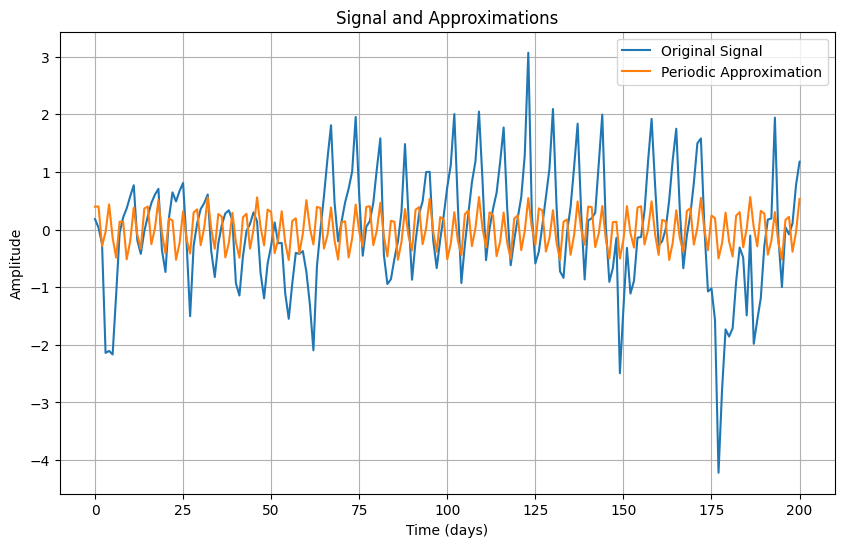

In [68]:
f_1, f_2 = 1/(frequencies[max_psd_idx])

y = signal_train
X = np.c_[np.cos(2*np.pi*f_1*time_array_train),
np.sin(2*np.pi*f_1*time_array_train),
np.cos(2*np.pi*f_2*time_array_train),
np.sin(2*np.pi*f_2*time_array_train),
np.ones_like(time_array_train)]

beta, *_ = np.linalg.lstsq(X, y, rcond=-1)

approx_season = X @ beta

plt.figure(figsize=(10, 6))
plt.plot(time_array_train, signal_train, label='Original Signal')
plt.plot(time_array_train, approx_season, label='Periodic Approximation')
plt.title('Signal and Approximations')
plt.xlabel('Time (days)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

## Studying the residual signal

### A simulated example

Simulate a MA(2) process and an AR(2) process.
For each plot the autocorrelation and partial autocorrelation.

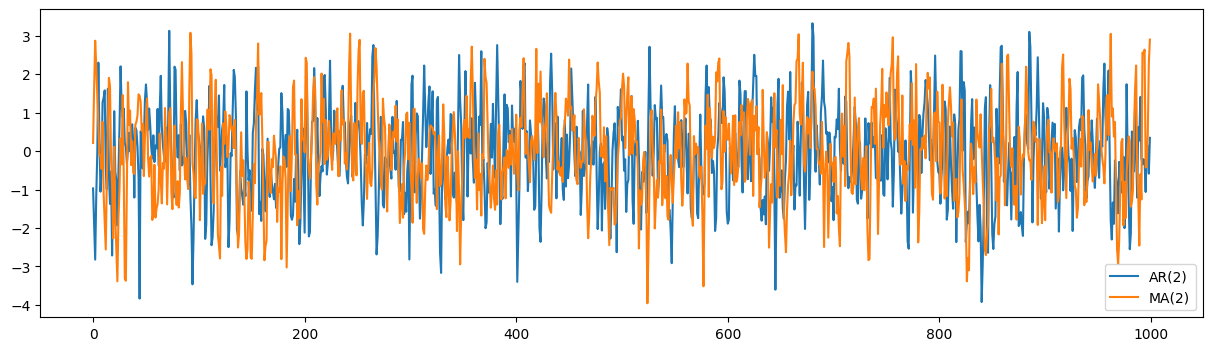

In [69]:
arparams = np.array([0.55, -0.25])  #
maparams = np.array([0.65, 0.35])

ar = np.r_[1, -arparams]  # add zero-lag and negate
ma = np.r_[1, maparams]  # add zero-lag


n_samples_simulated = 1000
ar2 = arma_generate_sample(ar, [1], n_samples_simulated)
ma2 = arma_generate_sample([1], ma, n_samples_simulated)

fig, ax = fig_ax()
ax.plot(ar2, label="AR(2)")
ax.plot(ma2, label="MA(2)")
_ = plt.legend()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


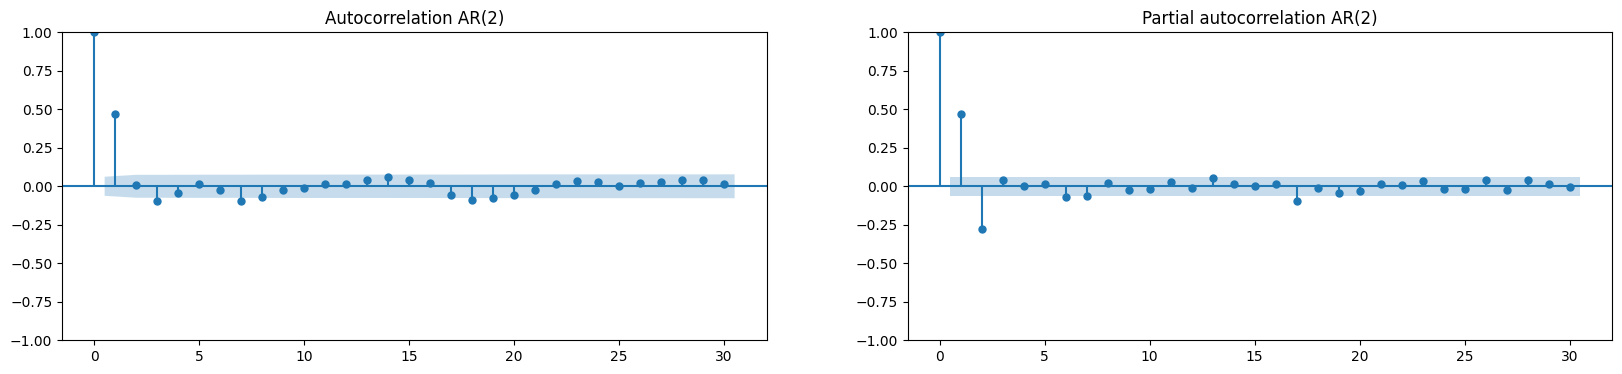

In [70]:
fig, (ax_0, ax_1) = plt.subplots(1, 2, figsize=(20, 4))
_ = plot_acf(ar2, ax=ax_0, title="Autocorrelation AR(2)")
_ = plot_pacf(ar2, ax=ax_1, title="Partial autocorrelation AR(2)")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


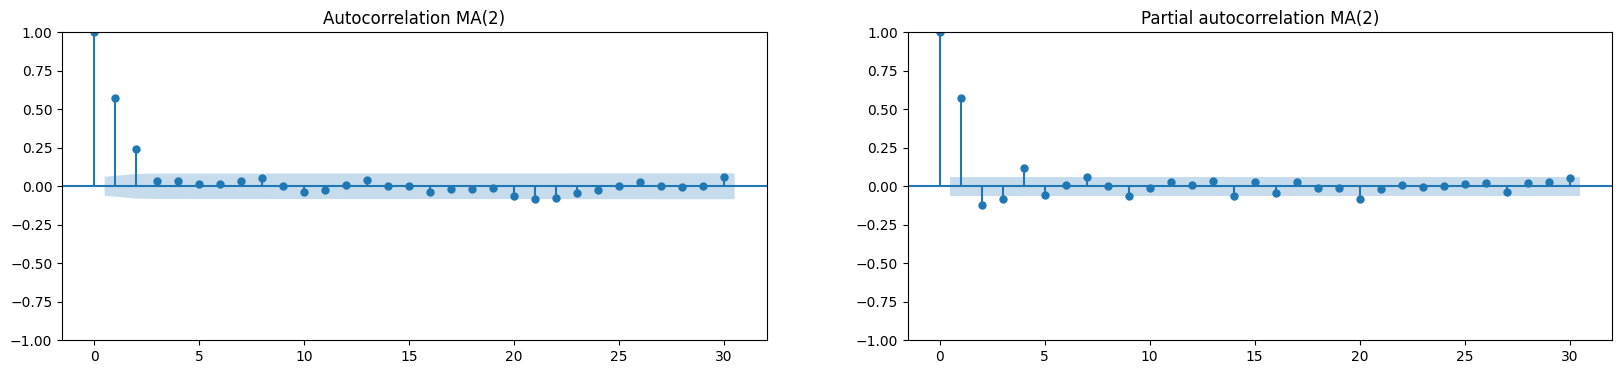

In [71]:
fig, (ax_0, ax_1) = plt.subplots(1, 2, figsize=(20, 4))
_ = plot_acf(ma2, ax=ax_0, title="Autocorrelation MA(2)")
_ = plot_pacf(ma2, ax=ax_1, title="Partial autocorrelation MA(2)")

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What would be a procedure to estimate the AR and MA order of a process?</p>
</div>

On utilise les plots d'autocorrélation et d'autocorrélation partielle.

La forme d'un process MA, son autocorrélation va à 0.

### Back to our problem

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Plot the autocorrelation and partial autocorrelation of the residual signal (without the constant and harmonic trend).</p>
</div>

In [93]:
residual_signal = signal_train-approx_season

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


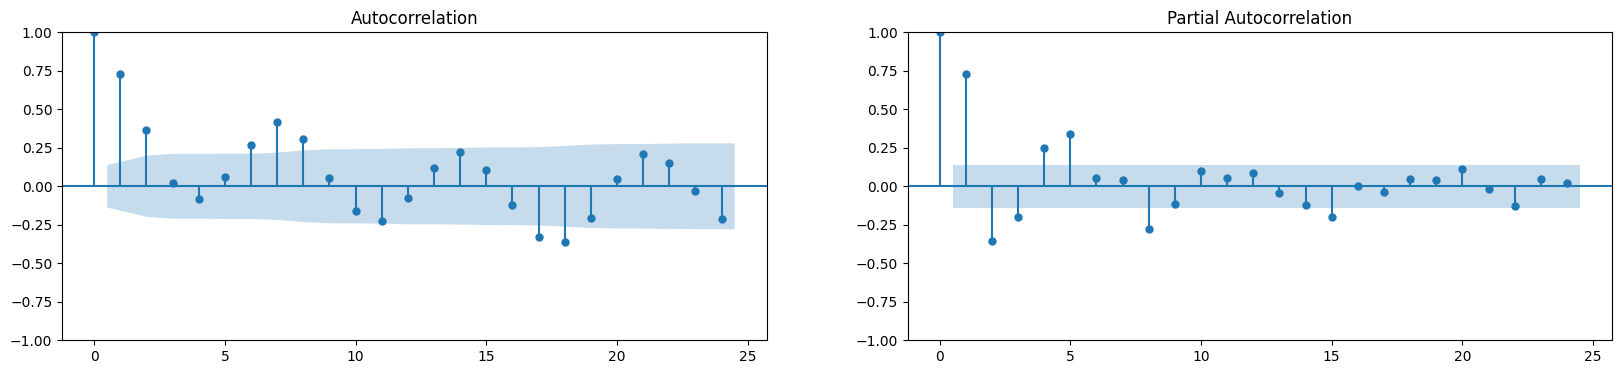

In [74]:
fig, (ax_0, ax_1) = plt.subplots(1, 2, figsize=(20, 4))
_ = plot_acf(residual_signal, ax=ax_0)
_ = plot_pacf(residual_signal, ax=ax_1)

Now, we fit an ARMA process on the residual signal.

In [77]:
ma_order = 7
ar_order = 8

# ma_order = 14
# ar_order = 15

res = ARIMA(residual_signal, order=(ar_order, 0, ma_order)).fit()
print(res.summary())

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  201
Model:                 ARIMA(8, 0, 7)   Log Likelihood                -145.714
Date:                Thu, 16 Nov 2023   AIC                            325.429
Time:                        11:22:38   BIC                            381.585
Sample:                             0   HQIC                           348.152
                                - 201                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0243      0.190     -0.128      0.898      -0.397       0.349
ar.L1          0.1206      1.430      0.084      0.933      -2.681       2.922
ar.L2          0.5689      1.049      0.542      0.5

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Using the fitted model, it is now possible to predict the value of the residual signal.

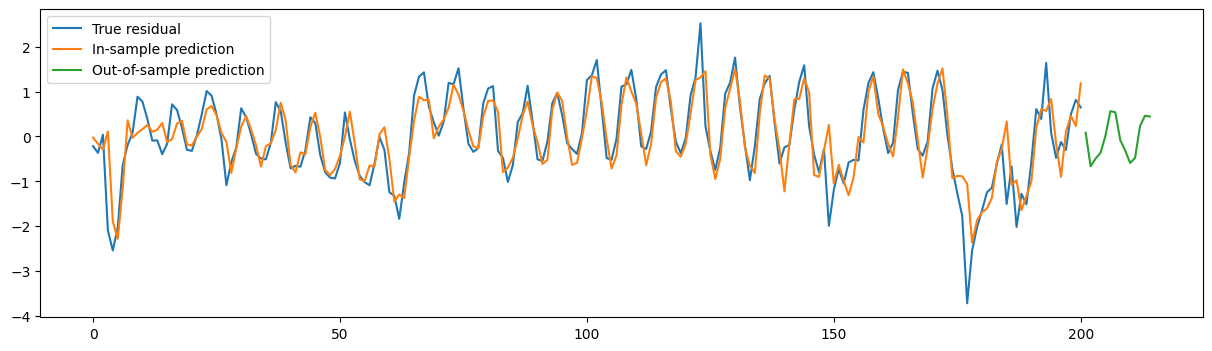

In [84]:
in_sample_pred = res.predict()
out_sample_pred = res.forecast(n_samples_pred)

fig, ax = fig_ax()
ax.plot(time_array_train, residual_signal, label="True residual")
ax.plot(time_array_train, in_sample_pred, label="In-sample prediction")
ax.plot(time_array_pred, out_sample_pred, label="Out-of-sample prediction")
_ = plt.legend()

### Final prediction

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Make and plot the final prediction for the taxi count (not normalized) for the next two weeks, using the trend, seasonal and residual processes.</p>
    <p>What do you conclude?</p>
</div>

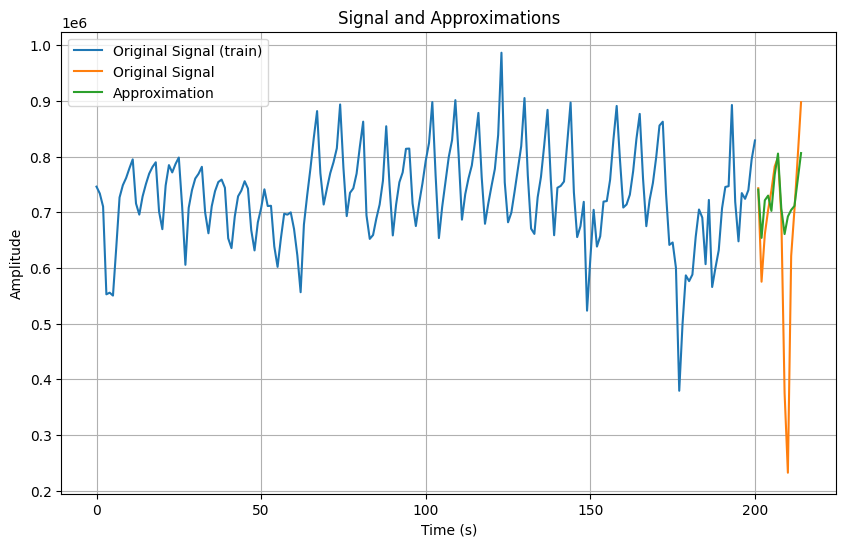

In [90]:
X_pred = np.c_[np.cos(2*np.pi*f_1*time_array_pred),
np.sin(2*np.pi*f_1*time_array_pred),
np.cos(2*np.pi*f_2*time_array_pred),
np.sin(2*np.pi*f_2*time_array_pred),
np.ones_like(time_array_pred)]

final_pred = X_pred @ beta + out_sample_pred
unscaled_final_pred = final_pred * scaler.scale_ + scaler.mean_
unscaled_real_signal = signal_pred * scaler.scale_ + scaler.mean_


plt.figure(figsize=(10, 6))
plt.plot(time_array_train, signal_train * scaler.scale_ + scaler.mean_, label='Original Signal (train)')
plt.plot(time_array_pred, unscaled_real_signal, label='Original Signal')
plt.plot(time_array_pred, unscaled_final_pred, label='Approximation')
plt.title('Signal and Approximations')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

### Stationarity checks

As was previously seen, the residual signal was not completely stationary since it still contained seasonal and low frequency components.
To assess this intuition, several statistical tests exists. Two of the most well-known are:

- the Dickey-Fuller test (H0: the signal has a unit root); 
- the Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test (H0: the signal is trend/level stationary vs H1:the signal has a unit root).

Actually, they do not test for stationarity but for symptoms of non-stationarity.

Car s'il a une racine unitaire, il n'est pas stationnaire (en gros ~).

In [94]:
adf_test(residual_signal)

Results of Dickey-Fuller Test:
Test Statistic                  -4.306562
p-value                          0.000433
#Lags Used                       8.000000
Number of Observations Used    192.000000
Critical Value (1%)             -3.464875
Critical Value (5%)             -2.876714
Critical Value (10%)            -2.574859
dtype: float64


<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What can you conclude from the test?</p>
</div>

Non, non-stationnaire

## Manage complex trend and outliers with SSA

With Singular Spectrum Analysis (SSA), it is possible to manage the low frequency trends and seasonnal effects with the same procedure.
SSA is often described as a "PCA for signals".

Let $y = \{y_t\}_t$ denote a $T$-sample long univariate signal, and $L$ a window length.
The trajectory matrix $X$ is formed by  $M$ lag-shifted copies of $y$, i.e.

$$
X:=
\begin{bmatrix}
y_1&y_2&y_3&\ldots&y_{L}\\
y_2&y_3&y_4&\ldots&y_{L+1}\\
y_3&y_4&y_5&\ldots&y_{L+2}\\
\vdots&\vdots&\vdots&\ddots&\vdots
\end{bmatrix}
$$


Now, write the Singular Value Decomposition (SVD) of $X$ is as follows:

$$
X = U\Sigma V^T = \sum_{i=1}^{L} X_i\quad\text{with}\quad X_i:= \sigma_i u_i v_i^T
$$

where $\sigma=\text{diag}(\sigma_1,\dots,\sigma_L)$ are the singular values sorted in descending order, $u_i$ and $v_i$ are respectively the associated left and right singular vectors corresponding to the columns of the orthogonal matrices $U$ and $V$.
Each $X_i$ is itself a trajectory matrix.

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>For a signal of length $T$ and a window of length $L$, what are the dimensions of the trajectory matrix (number of rows and columns)?</p>
</div>

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>How can you go from a trajectory matrix to a signal?</p>
</div>

Let us apply apply SSA on the signal.

In [ ]:
window_shape = 14
trajectory_matrix = get_trajectory_matrix(signal_train, window_shape)

In [ ]:
# SVD
u, eigenvals, vh = np.linalg.svd(trajectory_matrix, full_matrices=False)

NOTE: shape of signal depending on eigenvalue?

In [ ]:
plt.plot(eigenvals, "-*")

In [ ]:
ssa_decomposition = np.zeros((signal_train.size, window_shape))

for ind, (left, sigma, right) in enumerate(zip(u.T, eigenvals, vh)):
    ssa_decomposition.T[ind] = average_anti_diag(
        sigma * np.dot(left.reshape(-1, 1), right.reshape(1, -1))
    )

In [ ]:
fig, ax_arr = plt.subplots(
    nrows=window_shape // 3 + 1,
    ncols=3,
    figsize=(20, 3 * (window_shape // 3 + 1)),
)


for ind, (component, ax) in enumerate(zip(ssa_decomposition.T, ax_arr.flatten())):
    ax.plot(component)
    ax.set_xlim(0, component.size)
    ax.set_ylim(-2, 2)
    ax.set_title(f"Component n°{ind}")

In pratice, the trend (a slowly varying component), the periodic components and noise are well separated by SSA.

We can plot the successive reconstructions when adding one SSA component at a time.

In [ ]:
fig, ax_arr = plt.subplots(
    nrows=window_shape // 3 + 1,
    ncols=3,
    figsize=(20, 3 * (window_shape // 3 + 1)),
)

reconstruction = np.zeros(signal_train.size)

for component, ax in zip(ssa_decomposition.T, ax_arr.flatten()):
    reconstruction += component
    ax.plot(signal_train)
    ax.plot(reconstruction)
    ax.set_xlim(0, reconstruction.size)
    ax.set_ylim(-5, 4)

**Grouping**

Notice that several SSA components are very similar.
Usually they are summed together to deacrease the dimension of the representation.
This operation is called "grouping".

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>As in the previous tutorial, use a hierarchical clustering approach to group the SSA components together. (use the Euclidean distance and plot the associated dendogram.)</p>
</div>

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Report the groups that you found in the <tt>groups</tt> variable.</p>
</div>

In [ ]:
groups = [...]

Let us plot each SSA group individually.

In [ ]:
# grouping
grouped_ssa = np.zeros((signal_train.size, len(groups)))

for dim_ind, component_indexes in enumerate(groups):
    grouped_ssa.T[dim_ind] = np.take(ssa_decomposition, component_indexes, axis=-1).sum(
        axis=1
    )

fig, ax = fig_ax()
_ = ax.plot(grouped_ssa)

**Prediction**

The SSA components are then individually extrapolated by fitting an autoregressive model.
The extended components are summed to produce the forecast values.

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Make and plot the final prediction for the taxi count (not normalized) for the next two weeks, by fitting an AR(8) process (use <tt>AutoReg(signal_train, lags=8)</tt>) to each SSA component and summing the forecasts.</p>
</div>

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Conclude. (Is it better or worse than the previous approach? What can we do to improve the results? What is the limitation?)</p>
</div>